# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

In [1]:
pip install geoalchemy2

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# All import statements needed for the project, for example:

import json
import pathlib
import urllib.parse

import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db
import os
import numpy as np
import psycopg2

from datetime import datetime, timedelta
from sqlalchemy.orm import declarative_base
from shapely.geometry import Point
from shapely import wkt 

In [3]:
app_token = "Rl5BUiRawpr4H2LA9OQeKB47L"

In [4]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "ZIP_CODE_040114.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

NYC_DATA_APP_TOKEN = "FILL_ME_IN"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "FILL_ME_IN"
DB_USER = "FILL_ME_IN"
DB_URL = f"postgres+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [5]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

# 1 Data Preprocessing

## 1.1 Download 311 data and 2015 tree cencus data
### Generate Month Ranges Function
This code segment defines a function generate_month_ranges, which generates the date ranges for each month between a start date start_date and an end date end_date. It iteratively returns the start

In [8]:
def generate_month_ranges(start_date, end_date):
    current = start_date
    while current <= end_date:
        # Find the first day of the next month
        next_month = datetime(current.year + (current.month // 12), ((current.month % 12) + 1), 1)

        # Calculate the last day of the current month by subtracting one day from the first day of the next month
        month_end = next_month - timedelta(days=1)

        yield (current, month_end)
        current = next_month

# Set start date and end date
start_date = datetime(2015, 1, 1)
end_date = datetime(2023, 9, 30)

# Generate month's range
month_ranges = list(generate_month_ranges(start_date, end_date))

This script uses the generate_month_ranges function to obtain monthly date ranges from January 1, 2015, to September 30, 2023, and downloads the corresponding 311 complaint data from the New York City Open Data API for each time frame. For each month range, it constructs an API query to fetch data for specific fields and saves the result as a DataFrame. This DataFrame is then appended to a CSV file corresponding to the year. If the file does not exist, it creates a new one. Finally, it outputs a confirmation message indicating the completion of the data download.

In [29]:
for start, end in month_ranges:
    year = start.year
    csv_file = f"data/complaints_data_{year}.csv"
    print(f"Downloading data for the period: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

    query = f"created_date between '{start.strftime('%Y-%m-%dT%H:%M:%S')}' and '{end.strftime('%Y-%m-%dT%H:%M:%S')}'"
    response = requests.get(
        url="https://data.cityofnewyork.us/resource/erm2-nwe9.json",
        params={"$$app_token": app_token, "$where": query, "$limit": 999999,
                "$select": "unique_key, created_date, closed_date, agency,  complaint_type, descriptor, location_type, incident_zip, latitude, longitude, borough"
                }
    )
    data = response.json()
    batch_df = pd.DataFrame(data)


    mode = 'a' if os.path.exists(csv_file) else 'w'
    batch_df.to_csv(csv_file, mode=mode, index=False, header=not os.path.exists(csv_file))

print("Data download complete.")

Data download complete.


In [10]:
tree_data = requests.get(url="https://data.cityofnewyork.us/resource/5rq2-4hqu.json",
                         params={"$$app_token": app_token, "$limit": 99999999999999999999}).json()
tree_df = pd.DataFrame(tree_data)
tree_df.to_csv("data/tree.csv")

## 1.2 Data Cleaning & Filtering

### 1.2.1 311 Data Cleaning & Filtering
#### 311 Complaints Data Cleaning Function
1. Standardizing Zip Codes: It normalizes zip codes and handles anomalies, setting non-standard or missing values to NaN.

2. Dataframe Preparation: Reads the CSV file into a pandas DataFrame, removing rows with missing values and unspecified boroughs.

3. Type Conversion and Geospatial Preparation:
- Converts 'latitude' and 'longitude' to floats and 'created_date', 'closed_date' to datetime objects.
- Generates a 'geometry' column from 'latitude' and 'longitude' for geospatial analysis.
4. Creating GeoDataFrame: Transforms the DataFrame into a GeoDataFrame with the WGS84 (EPSG:4326) coordinate system, suitable for geospatial operations.

In [11]:
def clean_311_data(datafile):

    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0])
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 12000:
            return np.NaN
        return str(input_zip)

    #Read the file
    df = pd.read_csv(datafile, low_memory=False)

    #fix the zip
    df['incident_zip'] = df['incident_zip'].apply(fix_zip)

    df = df.dropna(how='any')

    #get rid of unspecified boroughs
    df = df[df['borough'] != 'Unspecified']

    df['latitude'] = df['latitude'].astype('float64')
    df['longitude'] = df['longitude'].astype('float64')

    #Converts the 'closed_date','created_date' column into a datetime object
    df['created_date'] = pd.to_datetime(df['created_date'])
    df['closed_date'] = pd.to_datetime(df['closed_date'])
    # Convert longitude and latitude to a 'geometry' column for geopandas
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # Create a GeoDataFrame and set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)
    gdf = gdf.reset_index(drop=True)
    
    return gdf

### 1.2.2 2015 Tree census Data Cleaning & Filtering

In [12]:
tree = pd.read_csv('data/tree.csv', usecols=['tree_id', 'the_geom',   'spc_common', 'status', 'health', 'zipcode', 'boroname', 'latitude', 'longitude'])
tree.to_csv('data/tree_data.csv',index=False)

In [13]:
def clean_tree_data(datafile):


    def fix_zip(input_zip):
        try:
            input_zip = int(float(input_zip))
        except:
            try:
                input_zip = int(input_zip.split('-')[0]) 
            except:
                return np.NaN
        if input_zip < 10000 or input_zip > 12000:
            return np.NaN
        return str(input_zip)

    # Read the file
    df = pd.read_csv(datafile)

    # Fix the zip
    df['zipcode'] = df['zipcode'].apply(fix_zip)

    df = df.dropna(how='any')

    # Make some columns name readable
    df.rename(columns={'the_geom': 'geometry', 'spc_common': 'species', 'boroname': 'borough'}, inplace=True)

    # Convert longitude and latitude to a 'geometry' column for geopandas
    df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

    # Create a GeoDataFrame and set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(epsg=4326, inplace=True)
    gdf = gdf.reset_index(drop=True)


    return gdf

In [14]:
tree = clean_tree_data('data/tree_data.csv')
tree.info()
tree.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 651235 entries, 0 to 651234
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   tree_id    651235 non-null  int64   
 1   geometry   651235 non-null  geometry
 2   status     651235 non-null  object  
 3   health     651235 non-null  object  
 4   species    651235 non-null  object  
 5   zipcode    651235 non-null  object  
 6   borough    651235 non-null  object  
 7   latitude   651235 non-null  float64 
 8   longitude  651235 non-null  float64 
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 44.7+ MB


,tree_id,geometry,status,health,species,zipcode,borough,latitude,longitude
0,180683,POINT (-73.84422 40.72309),Alive,Fair,red maple,11375,Queens,40.723092,-73.844215
1,200540,POINT (-73.81868 40.79411),Alive,Fair,pin oak,11357,Queens,40.794111,-73.818679
2,204026,POINT (-73.93661 40.71758),Alive,Good,honeylocust,11211,Brooklyn,40.717581,-73.936608
3,204337,POINT (-73.93446 40.71354),Alive,Good,honeylocust,11211,Brooklyn,40.713537,-73.934456
4,189565,POINT (-73.97598 40.66678),Alive,Good,American linden,11215,Brooklyn,40.666778,-73.975979


### 1.2.3 Zillow Data Cleaning & Filtering

#### Zillow Data Cleaning Function
This function cleans Zillow housing data specific to New York City. Key steps include:

1. Data Filtering: The function reads the data, filtering for entries where the 'City' is 'New York'.

2. Data Selection and Concatenation:

- Selects 'RegionName' (zipcode) and 'CountyName' columns.
- Grabs data from '2018-09-30' onwards.
- Concatenates these columns to form a single DataFrame.
3. Column Renaming and Conversion:

- Renames columns for better readability.
- Converts 'zipcode' to a string data type.
4. Reshaping Data:

- Uses the melt function to transform the DataFrame, creating a long format where each row represents a unique combination of zipcode, county, and date.
The output is a cleaned and reformatted DataFrame, ready for further analysis.

In [15]:
def clean_zillow_data(datafile):

    df = pd.read_csv(datafile, low_memory=False)

    df = df[df['City'] == 'New York']

    # Select the 'RegionName' and 'CountyName' columns and store them in df1
    df1 = df[['RegionName', 'CountyName']]
    # Select all columns from '2018-09-30' onwards and store them in df2
    df2 = df.loc[:, '2018-09-30':]

    # Concatenate df1 and df2 along the columns (axis=1)
    df = pd.concat([df1, df2], axis=1)

    # Make columns' name more readable
    df.rename(columns={'RegionName': 'zipcode', 'CountyName': 'county'}, inplace=True)

    # Convert the 'zipcode' column to a string data type
    df['zipcode'] = df['zipcode'].astype(str)

    df = df.melt(id_vars=["zipcode", "county"], var_name="date")
    
    df = df.reset_index(drop=True)

    return df

In [16]:
zillow = clean_zillow_data('data/zillow_rent_data.csv')
zillow.head()

,zipcode,county,date,value
0,11385,Queens County,2018-09-30,2401.525193
1,11208,Kings County,2018-09-30,NaN
2,11236,Kings County,2018-09-30,NaN
3,10467,Bronx County,2018-09-30,1773.839053
4,11373,Queens County,2018-09-30,NaN


### 1.2.4 Zipcode data Cleaning & Filtering

#### Zip Code Data Cleaning Function
This function is designed to clean and process zip code data using GeoPandas:

1. Reading Data: Loads the shapefile data into a GeoDataFrame.

2. Coordinate System Conversion: Converts the coordinate reference system to 'EPSG:4326' for standard geospatial analysis compatibility.

3. Column Selection and Renaming:

- Selects relevant columns: 'ZIPCODE' for zip code, 'POPULATION' for population figures, and 'geometry' for geographical shapes.
- Renames 'ZIPCODE' to 'zipcode' and 'POPULATION' to 'population' for consistency and clarity.
4. Index Resetting: Resets the index of the GeoDataFrame to ensure a clean, organized structure.

The function returns a cleaned GeoDataFrame with standardized zip code and population data, ready for geospatial analysis.

In [17]:
def clean_zipcode_data(datafile):

    gdf = gpd.read_file(datafile)

   
    gdf = gdf.to_crs('EPSG:4326')
    #Select specific columns
    gdf = gdf[['ZIPCODE', 'POPULATION', 'geometry' ]]

    gdf.rename(columns={'ZIPCODE':'zipcode', 'POPULATION':'population'}, inplace=True)
    gdf = gdf.reset_index(drop=True)
    

    return gdf

In [18]:
zipcode = clean_zipcode_data('data/nyc_zipcodes.shp')
print(zipcode.head())
zipcode.info()

  zipcode  population                                           geometry
0   11436     18681.0  POLYGON ((-73.80585 40.68291, -73.80569 40.682...
1   11213     62426.0  POLYGON ((-73.93740 40.67973, -73.93487 40.679...
2   11212     83866.0  POLYGON ((-73.90294 40.67084, -73.90223 40.668...
3   11225     56527.0  POLYGON ((-73.95797 40.67066, -73.95576 40.670...
4   11218     72280.0  POLYGON ((-73.97208 40.65060, -73.97192 40.650...
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   zipcode     263 non-null    object  
 1   population  263 non-null    float64 
 2   geometry    263 non-null    geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 6.3+ KB


# 2 Storing Data

## 2.1 Creating database
Setting up PostgreSQL Database: Creating a new PostgreSQL database named 'FINAL_PROJECT', enables the PostGIS extension for geographic data handling, and runs the 'schema.sql' file to define the database schema.

In [30]:
!createdb final_project
!psql --dbname final_project -c 'CREATE EXTENSION postgis;'
!psql --dbname final_project -f schema.sql

createdb: error: database creation failed: ERROR:  database "final_project" already exists
ERROR:  extension "postgis" already exists
psql:schema.sql:7: NOTICE:  relation "nyc_zip_codes" already exists, skipping
CREATE TABLE
psql:schema.sql:19: NOTICE:  relation "treecensus_2015" already exists, skipping
CREATE TABLE
psql:schema.sql:27: NOTICE:  relation "zillow_average_rents" already exists, skipping
CREATE TABLE
CREATE TABLE


In [31]:
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

## 2.2 Creating tables

#### Setting up Database Tables
This series of SQL statements and Python code is used to create tables in a PostgreSQL database for the 'final_project':

1. NYC Zip Codes Table: Creates a table named 'nyc_zip_codes' with fields for zip code, population, and geospatial geometry data.

2. Tree Census Table: Establishes a table 'treecensus_2015' to store data from the 2015 tree census, including tree status, health, species, zip code, borough, and geospatial coordinates.

3. Zillow Average Rents Table: Sets up a table 'zillow_average_rents' for storing Zillow's historical rent data by zip code, county, date, and value.

Using psycopg2, a Python PostgreSQL adapter, the script connects to the database and executes these SQL statements to create the tables, committing the changes to the database.

In [32]:
create_nyc_zipcodes_table = """
    CREATE TABLE IF NOT EXISTS nyc_zip_codes (
        id INTEGER PRIMARY KEY,
        zipcode INTEGER NOT NULL,
        population INTEGER,
        geometry geometry(Geometry, 4326)
    );
"""

In [33]:
create_trees_table = """
    CREATE TABLE IF NOT EXISTS tree_census_2015 (
        id INTEGER PRIMARY KEY,
        geometry geometry(Geometry, 4326),
        status VARCHAR,
        health VARCHAR,
        species VARCHAR,
        zipcode INTEGER,
        borough VARCHAR,
        latitude FLOAT,
        longitude FLOAT
    );
"""

In [34]:
create_zillow_table = """
    CREATE TABLE IF NOT EXISTS zillow_rents(
        id INTEGER PRIMARY KEY,
        zipcode INTEGER,
        county VARCHAR,
        date DATE,
        value FLOAT
    );
"""

In [35]:
cur.execute(create_nyc_zipcodes_table)
cur.execute(create_trees_table)
cur.execute(create_zillow_table)
conn.commit()

#### Creating Yearly 311 Complaint Tables
This script establishes individual tables for 311 complaints in the PostgreSQL database 'final_project' for each year from 2015 to 2023. Each table is named 'complaints311_' followed by the year. The tables have columns to store various attributes of 311 complaints such as IDs, creation and closure dates, agency, complaint type, descriptors, location, and geospatial data. It uses psycopg2 to connect and execute the SQL queries for table creation, and commits these changes to the database.

In [36]:
#Creating 311 tables by years
for year in range(2015, 2024):
    table_name = f"complaints311_{year}"
    create_table_query = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            id INTEGER PRIMARY KEY,
            created_date DATE,
            closed_date DATE,
            agency VARCHAR,
            complaint_type VARCHAR,
            descriptor VARCHAR,
            location_type VARCHAR,
            incident_zip INTEGER,
            latitude FLOAT,
            longitude FLOAT,
            borough VARCHAR,
            geometry geometry(Geometry, 4326)
        );
    """
    

    cur.execute(create_table_query)


conn.commit()

## 2.3 Inserting data

### 2.3.1 Inserting tree data

In [27]:
gdf=clean_tree_data('data/tree_data.csv')

# Prepare data for insertion
data_to_insert = [
    (row.Index, wkt.dumps(row.geometry), row.status, row.health, row.species, row.zipcode, row.borough, row.latitude, row.longitude)
                  for row in gdf.itertuples()]

# Insert data into the table
insert_query = """
    INSERT INTO tree_census_2015 (id, geometry, status, health, species, zipcode, borough, latitude, longitude)
    VALUES (%s, ST_GeomFromText(%s, 4326), %s, %s, %s, %s,%s, %s, %s);
"""
cur.executemany(insert_query, data_to_insert)

# Commit the changes
conn.commit()


### 2.3.2 Inserting 311 data

In [37]:
for year in range(2015, 2024):
    # Clean the data
    complaints = clean_311_data(f"data/complaints_data_{year}.csv")


    print(year)

    # Prepare the SQL statement for data insertion, dynamically updating the table name
    insert_query = f"""
        INSERT INTO complaints311_{year} (id, created_date, closed_date, agency, complaint_type, descriptor, location_type, incident_zip, latitude, longitude, borough, geometry)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, ST_GeomFromText(%s, 4326));
    """


    # Prepare the data to be inserted
    data_to_insert = [
        (row.Index, row.created_date, row.closed_date, row.agency, row.complaint_type, row.descriptor, row.location_type, row.incident_zip, row.latitude, row.longitude, row.borough, wkt.dumps(row.geometry))
        for row in complaints.itertuples()]


    # Execute the insertion
    cur.executemany(insert_query, data_to_insert)

    # Commit the changes
    conn.commit()

# Close the connection
conn.close()


2015
2016
2017
2018
2019
2020
2021
2022
2023


### 2.3.3 Inserting zillow data

In [38]:
# Connect to PostgreSQL
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Prepare data for insertion
data_to_insert = [
    (row.Index,  row.zipcode, row.county, row.date, row.value)
    for row in zillow.itertuples()]

# Insert data into the table
insert_query = """
    INSERT INTO zillow_rents (id,  zipcode, county, date, value)
    VALUES ( %s, %s,%s, %s, %s);
"""
cur.executemany(insert_query, data_to_insert)

# Commit the changes
conn.commit()


### 2.3.4 Inserting zipcodes data

In [39]:
# Prepare data for insertion
data_to_insert = [
    (row.Index,  row.zipcode, row.population, wkt.dumps(row.geometry) )
    for row in zipcode.itertuples()]

# Insert data into the table
insert_query = """
    INSERT INTO nyc_zip_codes (id,  zipcode, population, geometry)
    VALUES ( %s, %s,%s, ST_GeomFromText(%s, 4326));
"""
cur.executemany(insert_query, data_to_insert)

# Commit the changes
conn.commit()

# Close the conn
conn.close()

# 3 Understanding Data

## 3.1 Query 1: Which area might be more calm to live in?
Select 311 data between October 1st, 2022 and September 30th, 2023, and count the total number.


In [48]:
# Connect to the PostgreSQL database
conn = psycopg2.connect("dbname=final_project user=postgres password=123456")
cur = conn.cursor()

# Execute the SQL query
query_1 = """
    SELECT 
        incident_zip AS zipcode,
        COUNT(*) AS number_of_complaints
     FROM
        (SELECT * FROM complaints311_2022 WHERE created_date >= '2022-10-01'
         UNION ALL
         SELECT * FROM complaints311_2023 WHERE created_date <= '2023-09-30') AS combined_data
    WHERE  
        created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY
        incident_zip
    ORDER BY
        number_of_complaints DESC
"""

cur.execute(query_1)
result_1 = cur.fetchall()

columns_1 = ['zipcode', 'number_of_complaints']
result_of_query_1 = pd.DataFrame(result_1, columns=columns_1)
print(result_of_query_1)

conn.commit()


#Save the query to a sql file
with open('calm_areas_by_complaints.sql', 'w') as file:
    file.write(query_1)

     zipcode  number_of_complaints
0      11226                 42567
1      10467                 41205
2      10468                 38956
3      10452                 38498
4      10457                 36637
..       ...                   ...
230    10176                     3
231    10166                     2
232    10080                     1
233    10155                     1
234    10175                     1

[235 rows x 2 columns]


## 3.2 Query 2: Where has the most greenery?
According to zip codes, count each zipcodes' total tree number, descendingly order zipcodes, and choose the first 10 zipcodes as a result. 

In [50]:
# Execute the SQL query to find the top 10 zip codes with the most trees
query_2 = """
    SELECT 
        zipcode,
        COUNT(*) AS total_trees
    FROM
        tree_census_2015
    GROUP BY
        zipcode
    ORDER BY
        total_trees DESC
    LIMIT 10;
"""

cur.execute(query_2)
result_2 = cur.fetchall()
columns_2 = ['zipcode', 'total_trees']
result_of_query_2 = pd.DataFrame(result_2, columns = columns_2)
print(result_of_query_2)

conn.commit()


#Save the query to a sql file
with open('top_10_green_zipcodes.sql', 'w') as file:
    file.write(query_2)

   zipcode  total_trees
0    10312        21356
1    10314        16330
2    10306        12616
3    10309        12105
4    11234        10838
5    11385        10262
6    11357         9016
7    11207         8293
8    11208         7896
9    11434         7833


## 3.3 Query 3: Can I afford a place in the areas with the most trees?
Set a subquery named TopZipCodes to find the top 10 zip codes with the most trees. Then, join TopZipCodes with zillow_rents to get the average rents on these top 10 zip codes

In [53]:
# Execute the SQL query to find the average rent for the top 10 zip codes with the most trees
query_3 = """
    WITH TopZipCodes AS (
    SELECT 
        zipcode,
        COUNT(*) AS total_trees
    FROM 
        tree_census_2015
    GROUP BY 
        zipcode
    ORDER BY 
        COUNT(*) DESC
    LIMIT 10
    )
    SELECT 
    TopZipCodes.zipcode,
    total_trees,
    ROUND(CAST(AVG(zillow_rents.value) AS numeric), 2) AS average_rent
    FROM 
        TopZipCodes
    JOIN 
        zillow_rents ON TopZipCodes.zipcode = zillow_rents.zipcode
    WHERE 
        zillow_rents.date = '2023-08-31'
    GROUP BY 
        TopZipCodes.zipcode, total_trees
    ORDER BY 
        total_trees DESC;

"""

cur.execute(query_3)
result_3 = cur.fetchall()
#Convert Decimal type into python float
result_3 = [(zipcode, float(rent)) for zipcode, tree, rent in result_3]
columns_3 = ['zipcode', 'average_rent']
result_of_query_3 = pd.DataFrame(result_3, columns = columns_3)
print(result_of_query_3)

conn.commit()


#Save the query to a sql file
with open('affordable_green_areas_rent.sql', 'w') as file:
    file.write(query_3)

   zipcode  average_rent
0    10312       1775.09
1    10314       2465.47
2    10306       2331.54
3    10309       1832.01
4    11234       2312.31
5    11385       3064.48
6    11357       2458.81
7    11207       3079.09
8    11208       2737.55
9    11434       2645.92


## 3.4 Query 4: Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?
Set sub-table named HighRent (includes 5 zipcodes of the highest average rent), LowRent (includes 5 zipcodes of the lowest average rent), TreeCount (tree count for each zipcode), and ComplaintCount (complaints number for each zipcode). Use UnionAll and Join to create the final table.

In [54]:
# Execute the SQL query to find the 5 zip codes with the lowest and highest average rent for January 2023
query_4 = """
    WITH HighRent AS (
    SELECT 
        zillow_rents.zipcode,
        zillow_rents.value AS rent,
        RANK() OVER (ORDER BY zillow_rents.value DESC) AS rent_rank
    FROM 
        zillow_rents
    WHERE 
        zillow_rents.date = '2023-01-31' AND zillow_rents.value != 'NaN'
    ORDER BY 
        zillow_rents.value DESC 
    LIMIT 5
    ),
    LowRent AS (
        SELECT 
            zillow_rents.zipcode,
            zillow_rents.value AS rent,
            RANK() OVER (ORDER BY zillow_rents.value) AS rent_rank
        FROM 
            zillow_rents
        WHERE 
            zillow_rents.date = '2023-01-31' AND zillow_rents.value != 'NaN'
        ORDER BY 
            zillow_rents.value
        LIMIT 5
    ),
    TreeCount AS (
        SELECT 
            tree_census_2015.zipcode,
            COUNT(*) AS tree_count
        FROM 
            tree_census_2015
        GROUP BY 
            tree_census_2015.zipcode
    ),
    ComplaintCount AS (
        SELECT 
            complaints311_2023.incident_zip AS zipcode,
            COUNT(*) AS complaint_count
        FROM 
            complaints311_2023
        WHERE 
            complaints311_2023.created_date BETWEEN '2023-01-01' AND '2023-01-31'
        GROUP BY 
            complaints311_2023.incident_zip
    )
    SELECT 
        combined_rents.zipcode,
        combined_rents.rent AS average_rent,
        COALESCE(TreeCount.tree_count, 0) AS tree_count,
        COALESCE(ComplaintCount.complaint_count, 0) AS complaint_count
    FROM 
        (SELECT * FROM HighRent UNION ALL SELECT * FROM LowRent) AS combined_rents
    LEFT JOIN 
        TreeCount ON combined_rents.zipcode = TreeCount.zipcode
    LEFT JOIN 
        ComplaintCount ON combined_rents.zipcode = ComplaintCount.zipcode
    ORDER BY 
        combined_rents.rent DESC;
    

"""

cur.execute(query_4)
result_4 = cur.fetchall()

#Convert rent data into readable format
result_4 = [(zipcode, round(rent, 2), tree_count, complaint_count) for zipcode, rent, tree_count, complaint_count in result_4]

columns_4 = ['zipcode', 'average_rent', 'tree_count', 'complaint_count']
result_of_query_4 = pd.DataFrame(result_4, columns = columns_4)
print(result_of_query_4)



conn.commit()


#Save the query to a sql file
with open('rent_trees_complaints_correlation.sql', 'w') as file:
    file.write(query_4)

   zipcode  average_rent  tree_count  complaint_count
0    10007       7270.24         338              144
1    10282       7143.35         230               22
2    10013       5480.11        1132              522
3    10069       4959.67         112               27
4    10011       4741.87        2040             1109
5    10458       1883.08        3212             3314
6    11357       1829.66        9016              636
7    10453       1820.23        2874             2766
8    10462       1801.89        4048             1947
9    10309       1380.51       12105              520


## 3.5 Query 5: Where has the most greenery (take 2)?
According to the coordinate point of the tree is inside the polygon boundary of the zipcodes, find the top 10 zip codes with the most trees.

In [55]:
# Execute the SQL query to find the top 10 zip codes with the most trees
query_5 = """
    SELECT 
    nyc_zip_codes.zipcode,
    COUNT(tree_census_2015.id) AS total_trees
    FROM 
        tree_census_2015
    JOIN 
        nyc_zip_codes 
    ON 
        ST_COntains(nyc_zip_codes.geometry, tree_census_2015.geometry)
    GROUP BY 
        nyc_zip_codes.zipcode
    ORDER BY 
        total_trees DESC
    LIMIT 10;

"""

cur.execute(query_5)
result_5 = cur.fetchall()

columns_5 = ['zipcode', 'total_trees']
result_of_query_5 = pd.DataFrame(result_5, columns = columns_5)
print(result_of_query_5)


conn.commit()


#Save the query to a sql file
with open('greenery_distribution_by_zipcode.sql', 'w') as file:
    file.write(query_5)

   zipcode  total_trees
0    10312        21356
1    10314        16330
2    10306        12616
3    10309        12105
4    11234        10838
5    11385        10262
6    11357         9016
7    11207         8294
8    11208         7897
9    11434         7833


## 3.6 Query 6: What is the immediate area like?

In [56]:
query_6 = """
    SELECT 
    id, 
    species, 
    health, 
    status, 
    ST_AsText(geometry) AS tree_location
FROM 
    tree_census_2015
WHERE 
    ST_DWithin(
        geometry::geography, 
        ST_SetSRID(ST_MakePoint(-73.96253174434912, 40.80737875669467), 4326)::geography, 
        804.672
    );


"""

cur.execute(query_6)
result_6 = cur.fetchall()

columns_6 = ['ID', 'species', 'health', 'status', 'location']
result_of_query_6 = pd.DataFrame(result_6, columns = columns_6)
print(result_of_query_6)


# Commit the changes (if applicable)
conn.commit()


#Save the query to a sql file
with open('trees_near_campus.sql', 'w') as file:
    file.write(query_6)

          ID           species health status                         location
0         66           pin oak   Good  Alive   POINT(-73.9620798 40.80230109)
1        105  London planetree   Good  Alive  POINT(-73.96331506 40.80881155)
2        115  London planetree   Good  Alive  POINT(-73.96340334 40.80874458)
3        117        willow oak   Good  Alive  POINT(-73.96071917 40.80572583)
4        119      American elm   Fair  Alive  POINT(-73.96412322 40.81114538)
...      ...               ...    ...    ...                              ...
2767  647506      sawtooth oak   Fair  Alive  POINT(-73.96443635 40.80082766)
2768  648698        willow oak   Good  Alive   POINT(-73.9606236 40.80568587)
2769  649279  northern red oak   Good  Alive  POINT(-73.96219168 40.80234813)
2770  649493  Japanese zelkova   Good  Alive  POINT(-73.96133691 40.80598414)
2771  651028            ginkgo   Good  Alive  POINT(-73.96002723 40.80075951)

[2772 rows x 5 columns]


# Visualizing Data

## Visualization 1: What can I expect to put up with in NYC?
Visualize the daily complaints for the top 3 complaint types between 2022-10-01 and 2023-09-30. Firstly, select corresponding data from complaints311, count the total number for each type, and only keep the first three complaint types. Use matplotlib to plot the trends.

In [58]:
def visualize_top_complaints(conn, start_date, end_date):
    visualize_1 = """
        SELECT
            complaint_type,
            COUNT(*) AS number_of_complaints
        FROM
            (SELECT * FROM complaints311_2022 WHERE created_date >= '2022-10-01'
            UNION ALL
            SELECT * FROM complaints311_2023 WHERE created_date <= '2023-09-30') AS combined_data
        WHERE
            created_date BETWEEN '2022-10-01' AND '2023-09-30'
        GROUP BY
            complaint_type
        ORDER BY
            number_of_complaints DESC
        LIMIT 3;
    """
    cur.execute(visualize_1)
    top_complaints = pd.DataFrame(cur.fetchall(), columns=['complaint_type', 'number_of_complaints'])
    
    for complaint_type in top_complaints['complaint_type']:
        # SQL query to get daily complaints for each complaint type
        daily_complaints_query = f"""
            SELECT
                created_date,
                COUNT(*) AS daily_complaints
            FROM
                (SELECT * FROM complaints311_2022 WHERE created_date >= '2022-10-01'
                UNION ALL
                SELECT * FROM complaints311_2023 WHERE created_date <= '2023-09-30') AS combined_data
            WHERE
                created_date BETWEEN '{start_date}' AND '{end_date}'
                AND complaint_type = '{complaint_type}'
            GROUP BY
                created_date
            ORDER BY
                created_date;
        """
    
        cur.execute(daily_complaints_query)
        daily_complaints = pd.DataFrame(cur.fetchall(), columns=['created_date', 'daily_complaints'])
    
        plt.plot(daily_complaints['created_date'], daily_complaints['daily_complaints'], label=complaint_type)
    
    # Customize the plot
    plt.title('Daily Complaints for Top 3 Complaint Types')
    plt.xlabel('Date')
    plt.ylabel('Number of Complaints')
    plt.legend()
    plt.show()
    


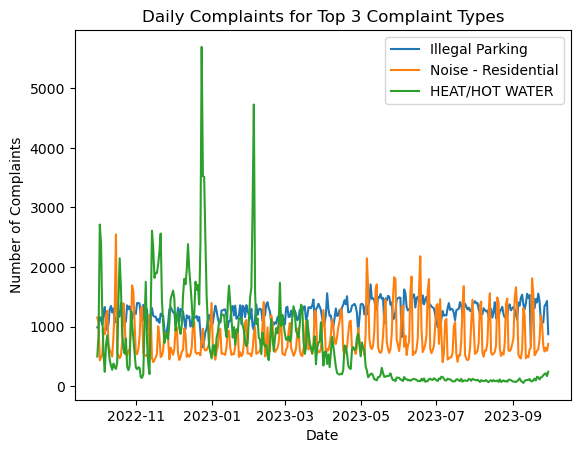

In [59]:
visualize_top_complaints(conn, '2022-10-01', '2023-09-30')

## Visualization 2: What are the most common complaints in the immediate area?
Create a visualize_top_complaintgs_by_zipcode function, import conn, zipcode, start year and end year which select complaints311 from start year to end year and filter by a certain zipcode count number of complains by complaint types, and list and plot the top 10.


In [60]:
def visualize_top_complaints_by_zipcode(conn, zipcode, start_year, end_year):
    table_names = [f'complaints311_{year}' for year in range(start_year, end_year + 1)]

    top_10_complaints_query = f"""
        SELECT
            complaint_type,
            COUNT(*) AS number_of_complaints
        FROM
            ({' UNION ALL '.join(f'SELECT * FROM {table}' for table in table_names)}) AS combined_data
        WHERE
            incident_zip = {zipcode}
        GROUP BY
            complaint_type
        ORDER BY
            number_of_complaints DESC
        LIMIT 10;
    """

    cur.execute(top_10_complaints_query)
    top_10_complaints = pd.DataFrame(cur.fetchall(), columns=['complaint_type', 'number_of_complaints'])

    plt.bar(top_10_complaints['complaint_type'], top_10_complaints['number_of_complaints'], color='skyblue')

    plt.title(f'Top 10 Complaints in Zip Code {zipcode} ({start_year}-{end_year})')
    plt.xlabel('Complaint Type')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

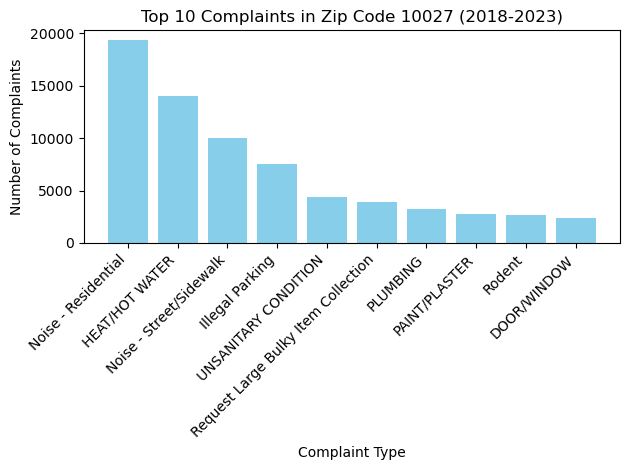

In [61]:
visualize_top_complaints_by_zipcode(conn, 10027, 2018, 2023)

## Visualization 3: Is there any correlation between rent, trees, and complaints at all?
Create a visualize rent trees complaints function, import conn, start date and end date which calculates the average rents from start year to end year and count the total complaints number and trees from start year to end year corresponding to the same zipcode.

In [62]:
def visualize_rent_trees_complaints(conn, start_date, end_date):
    rent_query = f"""
    SELECT zipcode, AVG(value) as average_rent
    FROM zillow_rents
    WHERE date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY zipcode;
    """
    cur.execute(rent_query)
    df_rent = pd.DataFrame(cur.fetchall(), columns=['zipcode', 'average_rent'])


    tree_query = """
    SELECT zipcode, COUNT(*) as tree_count
    FROM tree_census_2015
    GROUP BY zipcode;
    """
    cur.execute(tree_query)
    df_trees = pd.DataFrame(cur.fetchall(), columns=['zipcode', 'tree_count'])


    complaint_query_parts = []
    for year in range(2015, 2024):  
        complaint_query_parts.append(
            f"SELECT incident_zip AS zipcode, COUNT(*) as complaint_count FROM complaints311_{year} WHERE created_date BETWEEN '{start_date}' AND '{end_date}' GROUP BY incident_zip"
        )
    
    complaint_query = " UNION ALL ".join(complaint_query_parts)
    complaint_query = f"""
        SELECT zipcode, SUM(complaint_count) as total_complaint_count
        FROM ({complaint_query}) as subquery
        GROUP BY zipcode;
    """
    
    cur.execute(complaint_query)
    df_complaints = pd.DataFrame(cur.fetchall(), columns=['zipcode', 'total_complaint_count'])
    
    df_merged = df_rent.merge(df_trees, on='zipcode', how='inner')
    df_merged = df_merged.merge(df_complaints, on='zipcode', how='inner')
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))


    ax1.scatter(df_merged['average_rent'], df_merged['tree_count'], color='green')
    ax1.set_title('Rent vs. Number of Trees by Zip Code')
    ax1.set_ylabel('Number of Trees')


    ax2.scatter(df_merged['average_rent'], df_merged['total_complaint_count'], color='blue')
    ax2.set_title('Rent vs. Number of Complaints by Zip Code')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Number of Complaints')


    plt.tight_layout()
    plt.show()

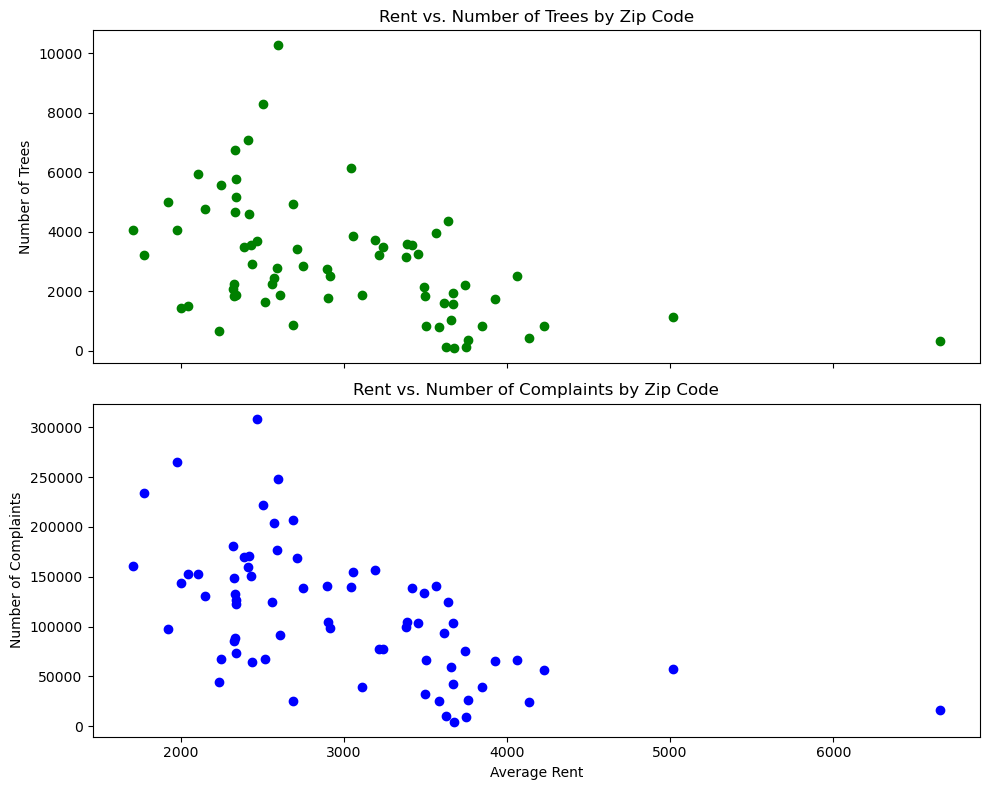

In [63]:
visualize_rent_trees_complaints(conn, '2015-01-01', '2023-09-30')

## 4.4 Visualization 4: If I can afford more in rent, will there be fewer issues & complaints?
The function visualize_rent_vs_complaints queries and combines data on average rents and complaint counts by zip code, categorizes rents into bins, and visualizes the relationship between rent levels and complaint counts using a boxplot.

In [64]:
def visualize_rent_vs_complaints(conn, start_date, end_date):
    rent_query = """
    SELECT zipcode, value AS average_rent
    FROM zillow_rents
    WHERE date = '2023-09-30';
    """
    cur.execute(rent_query)
    df_rent = pd.DataFrame(cur.fetchall(), columns=['zipcode', 'average_rent'])

    complaint_query_2022 = f"""
    SELECT incident_zip AS zipcode, COUNT(*) as complaint_count
    FROM complaints311_2022
    WHERE created_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY incident_zip;
    """
    cur.execute(complaint_query_2022)
    df_complaints_2022 = pd.DataFrame(cur.fetchall(), columns=['zipcode', 'complaint_count'])

    complaint_query_2023 = f"""
    SELECT incident_zip AS zipcode, COUNT(*) as complaint_count
    FROM complaints311_2023
    WHERE created_date <= '{end_date}'
    GROUP BY incident_zip;
    """
    cur.execute(complaint_query_2023)
    df_complaints_2023 = pd.DataFrame(cur.fetchall(), columns=['zipcode', 'complaint_count'])

    df_complaints = pd.concat([df_complaints_2022, df_complaints_2023])
    df_complaints = df_complaints.groupby('zipcode').sum().reset_index()

    df_merged = df_rent.merge(df_complaints, on='zipcode', how='inner')

    df_merged['rent_bin'] = pd.cut(df_merged['average_rent'], bins=range(0, int(df_merged['average_rent'].max()) + 1000, 1000), right=False)

    plt.figure(figsize=(12, 6))
    df_merged.boxplot(column='complaint_count', by='rent_bin', grid=False)

    plt.title('Number of Complaints vs. Rent Bins')
    plt.suptitle('')
    plt.xlabel('Rent Bins ($)')
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=45)
    plt.show()

<Figure size 1200x600 with 0 Axes>

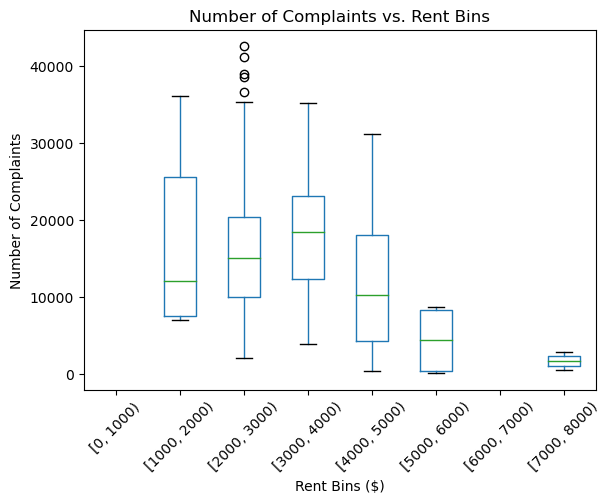

In [65]:
visualize_rent_vs_complaints(conn, '2022-10-01', '2023-09-30')

## 4.5 Visualization 5: Where were the recent 311 incidents reported from in the immediate area?
The function retrieves 311 complaints data from start year to end year and geographical radius from a given coordinate. It creates a circular area around the coordinate and visualizes nearby complaints on a map using GeoPandas and Matplotlib.

In [66]:
def visualize_nearby_complaints(conn, start_date, end_date, longitude, latitude, radius=1):

    # Get 311 complaints data
    complaint_query = f"""
    SELECT latitude, longitude
    FROM complaints311_2023
    WHERE created_date BETWEEN '{start_date}' AND '{end_date}'
    AND latitude IS NOT NULL AND longitude IS NOT NULL;
    """
    cur.execute(complaint_query)
    complaints = pd.DataFrame(cur.fetchall(), columns=['latitude', 'longitude'])

    # Convert data to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        complaints, geometry=gpd.points_from_xy(complaints.longitude, complaints.latitude)
    )
    gdf.crs = {'init': 'epsg:4326'}

    
    center_point = Point(longitude, latitude)
    circle = center_point.buffer(radius / 111)  # approximately 1km radius
    
    gdf = gdf[gdf.within(circle)]

    # Plot map
    gdf.plot(marker='o', color='red', markersize=5)
    plt.title(f'311 Complaints Near Coordinate ({longitude}, {latitude})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


/Users/jayfeng/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


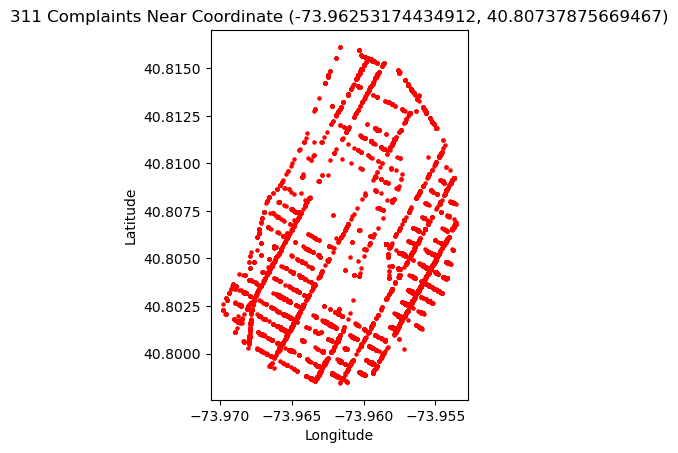

In [67]:
visualize_nearby_complaints(conn, '2023-01-01', '2023-09-30', -73.96253174434912, 40.80737875669467)

## 4.6 Visualization 6: Are areas trying to improve the amount of trees in the neighborhood?\]\
The function queries geometry from tree_census_2015 within start date and end data and retreives 'new tree request' from complaints311 within the same year range. Plot these datasets.

In [68]:
def visualize_trees_and_new_tree_requests(conn, start_date, end_date):
    tree_query = "SELECT geometry FROM tree_census_2015;"
    cur.execute(tree_query)
    trees = gpd.GeoDataFrame.from_postgis(tree_query, conn, geom_col='geometry')

    complaint_query_parts = []
    for year in range(2018, 2024): 
        complaint_query_parts.append(
            f"SELECT geometry FROM complaints311_{year} WHERE complaint_type = 'New Tree Request' AND created_date BETWEEN '{start_date}' AND '{end_date}'"
        )
    complaint_query = " UNION ALL ".join(complaint_query_parts)
    new_tree_requests = gpd.GeoDataFrame.from_postgis(complaint_query, conn, geom_col='geometry')

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    trees.plot(ax=ax, marker='o', color='green', markersize=5, label='Trees')
    new_tree_requests.plot(ax=ax, marker='x', color='red', markersize=5, label='New Tree Requests')

    plt.title('Trees and New Tree Requests in NYC')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

/Users/jayfeng/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/jayfeng/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


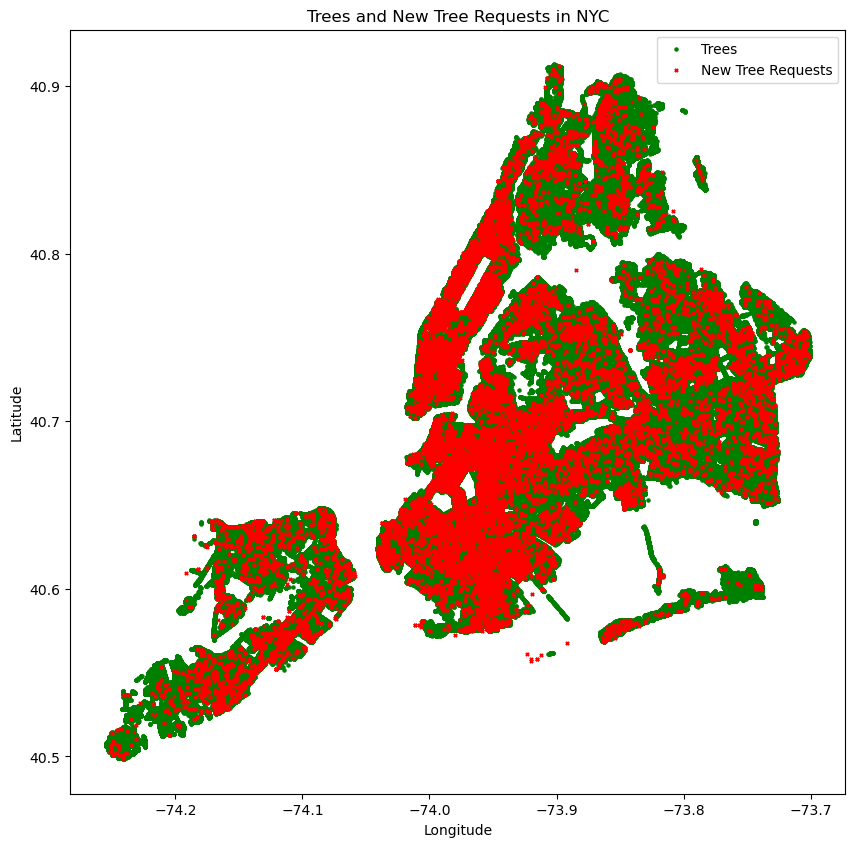

In [69]:
visualize_trees_and_new_tree_requests(conn, '2018-10-01', '2023-09-30')
